### Sources
* App data: https://apify.com/epctex/appstore-scraper
* Agency data: https://catalog.data.gov/dataset/national-transit-map-agencies
* Income data: https://www.bea.gov/data/income-saving/personal-income-county-metro-and-other-areas

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Web Scrape Walk/Bike/Transit Scores

In [2]:
url = "https://www.walkscore.com/cities-and-neighborhoods/"
page = requests.get(url)

soup = BeautifulSoup(page.content, "html.parser")
table = soup.find(id='citysort')

with open("scores.html", "w") as file:
    file.write(str(table))

scores_data = pd.read_html("data/scores.html")[0]

### Merge Data

In [3]:
# Merge app data and agency data
app_data = pd.read_csv("data/app_data.csv")
app_data.drop(['artistId', 'averageUserRatingForCurrentVersion', 'primaryGenreName', 'genres/0', 'genres/1'], axis=1, inplace=True)

agency_data = pd.read_csv("data/National_Transit_Map_Agencies.csv")
agency_data.drop(['In_Latest_NTAD_Upload'], axis=1, inplace=True)

merged_data = app_data.merge(agency_data, left_on='agency', right_on='Agency_Name')
merged_data.loc[merged_data['City'] == 'Brooklyn', 'City'] = 'New York'
merged_data.loc[merged_data['City'] == 'Orange', 'City'] = 'Irvine'

In [4]:
# merge (app + agency) data with scores
merged_data = merged_data.merge(scores_data, on='City')
merged_data['Transit Score'] = merged_data['Transit Score'].apply(float)
merged_data['Walk Score'] = merged_data['Walk Score'].apply(float)

In [5]:
# merge (app + agency + scores) data with income data
merged_data.loc[:, 'County'] = ['Shelby',
                                'Miami-Dade',
                                'Kings County',
                                'Orange',
                                'Wayne',
                                'Maricopa',
                                'Orange',
                                'Duval',
                                'Philadelphia',
                                'Polk',
                                'Alameda',
                                'Denver',
                                'Clark',
                                'Los Angeles']

income_data = pd.read_csv("data/income_data.csv")
income_data.iloc[:, 1].dropna(axis=0, inplace=True)
income_data.columns = ['county', 'inc_2019', 'inc_2020', 'inc_2021', 
                       'rank_in_state', 'per_change_2020', 'per_change_2021',
                       'rank_in_state2', 'state']

# previously_merged = pd.read_csv("output2.csv")

merged_data = merged_data.merge(income_data, left_on=['State_x', 'County'], right_on=['state', 'county'])
merged_data['inc_2021'] = merged_data['inc_2021'].apply(lambda x: int(str(x).replace(',', '')))

In [6]:
# Merge (app + agency + scores + income) data with ridership data
ridership = pd.read_csv("data/august_ridership.csv")[['NTD ID', '2023']].dropna()
ridership['2023'] = ridership['2023'].apply(lambda x: int(str(x).replace(',', '')))
ridership = ridership.groupby("NTD ID").sum()

merged_data = merged_data.merge(ridership, left_on=['NTD_ID'], right_on=['NTD ID'])

In [7]:
# Manually entering datat from US census estimates
vehicle_ridership = [358659,
                     902386 + 118513,
                     1076611 + 146548,
                     1076611 + 146548,
                     534356 + 61116,
                     1421356 + 220384,
                     350234 + 48251,
                     345311 + 49850,
                     195227 + 21238,
                     430950 + 64666,
                     236808 + 27252,
                     773602 + 116324,
                     3055959 + 471603]

pt_ridership = [1599,
                44567,
                18152,
                18152,
                11605,
                20741,
                4128,
                115670,
                1604,
                57111,
                18440,
                25696,
                181582]

In [8]:
from sklearn import preprocessing

data = [vehicle_ridership, pt_ridership]
scaler = preprocessing.Normalizer()
scaler.fit(data)
data = scaler.transform(data)
# data = [list(l) for l in data]
merged_data.loc[:, 'vehicle_ridership'] = data[0]
merged_data.loc[:, 'pt_ridership'] = data[1]

In [10]:
# Remove on-demand apps
merged_data = merged_data.drop([0, 1, 2, 4])

### Make Visualizations

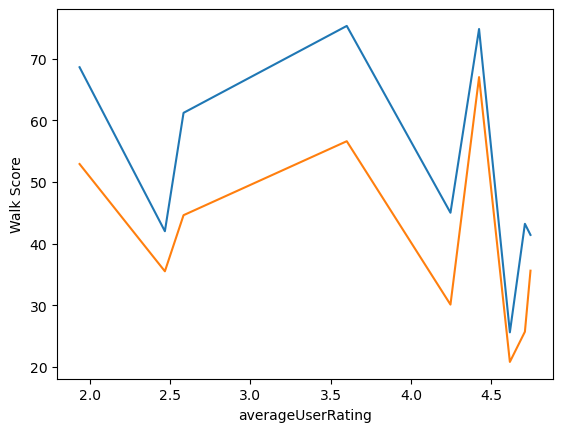

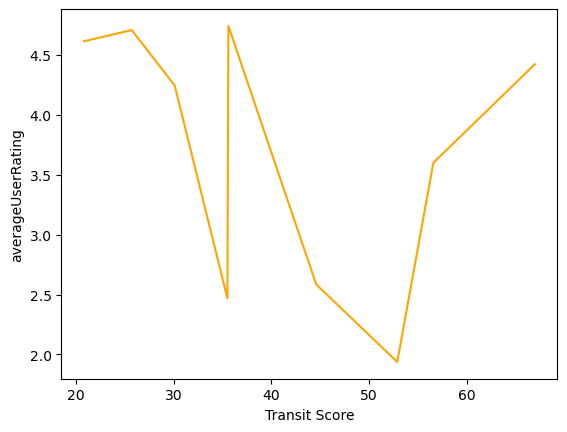

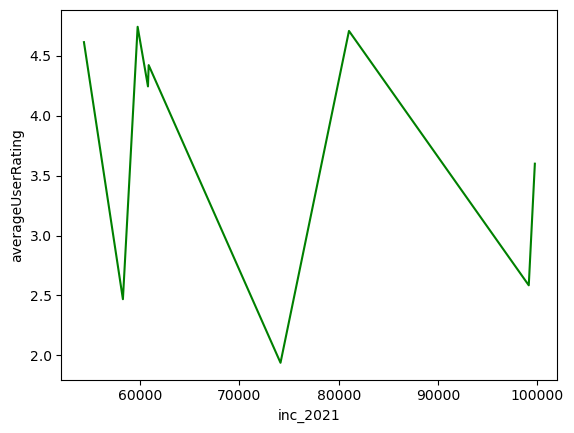

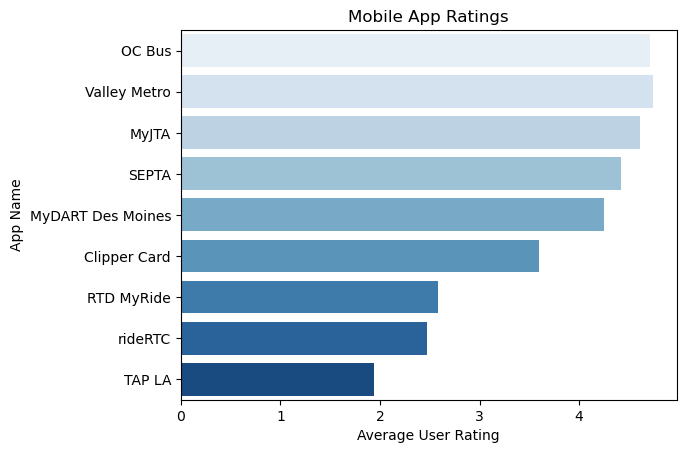

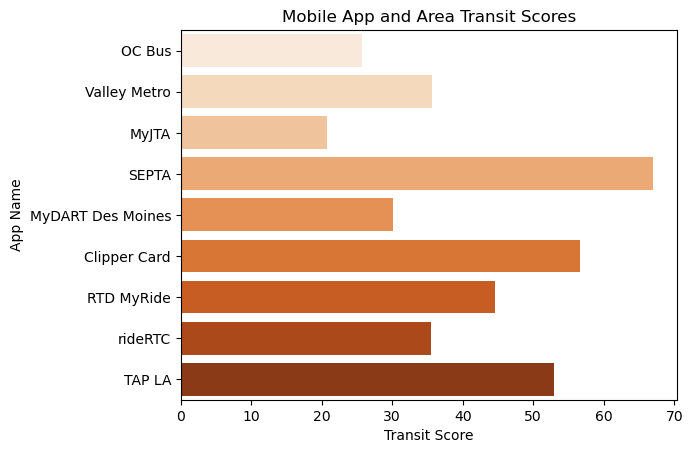

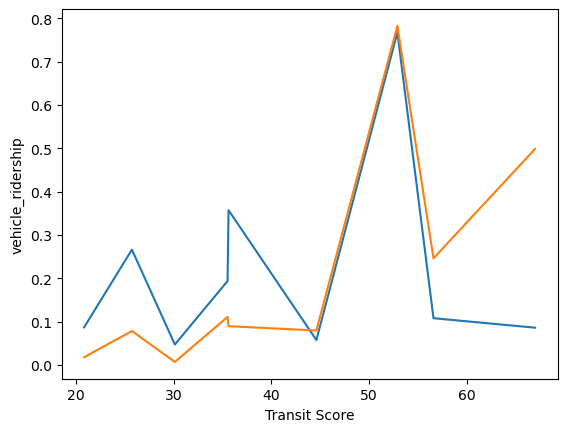

In [15]:
sns.lineplot(merged_data, x='averageUserRating', y='Walk Score')
sns.lineplot(merged_data, x='averageUserRating', y='Transit Score')
plt.show()

sns.lineplot(merged_data, x='Transit Score', y='averageUserRating', color='orange')
plt.show()

sns.lineplot(merged_data, x='inc_2021', y='averageUserRating', color='green')
plt.show()

# apps = sns.barplot(merged_data, x='averageUserRating', y='trackName', palette="Blues")
# apps.set(xlabel="Average User Rating", ylabel="App Name", title="Mobile App Ratings")
# plt.show()

ratings = sns.barplot(merged_data, x='averageUserRating', y='trackName', palette='Blues')
ratings.set(xlabel="Average User Rating", ylabel="App Name", title="Mobile App Ratings")
plt.show()
transit_scores = sns.barplot(merged_data, x='Transit Score', y='trackName', palette='Oranges')
transit_scores.set(xlabel="Transit Score", ylabel="App Name", title="Mobile App and Area Transit Scores")
plt.show()

sns.lineplot(merged_data, x='Transit Score', y='vehicle_ridership')
sns.lineplot(merged_data, x='Transit Score', y='pt_ridership')
plt.show()